IMPORTING LIBRARIES

In [1]:
import numpy as np
import numpy.linalg as LA
import math
import matplotlib.pyplot as plt
from pysindy.feature_library import CustomLibrary
from scipy.stats import invgamma, bernoulli, beta
from scipy.special import gamma, gammaln
from scipy.signal import butter, filtfilt
from sklearn.linear_model import LinearRegression
import torch

## PREPROCESSING HELPER FUNCTIONS

In [2]:
def butter_filter(data):
    # Filter requirements.
    T = 5.0         # Sample Period
    fs = 30 #1/dt       # sample rate, Hz
    cutoff = 2      # desired cutoff frequency of the filter, Hz ,      slightly higher than actual 1.2 Hz
    nyq = 0.5 * fs  # Nyquist Frequency
    order = 2       # sin wave can be approx represented as quadratic
    # nnn = int(T * fs) # total number of samples

    normal_cutoff = cutoff / nyq
    # Get the filter coefficients 
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

In [3]:
def filter(x):
    for k in range(x.shape[-1]):
        x[:,k] = butter_filter(x[:,k])
    # print('after filter', x[0,0])
    return x

In [4]:
def get_data(filename_x, filename_xdot, t_final, targets=1):
    data_x = np.genfromtxt(filename_x, delimiter=',').T
    data_xdot = np.genfromtxt(filename_xdot, delimiter=',').T
    
    if targets==1:
        data_x = np.reshape(data_x, (data_x.shape[0],1))
        data_xdot = np.reshape(data_xdot, (data_xdot.shape[0],1))
        
    t = np.linspace(0, t_final, data_x.shape[0])
    # print('after importing', data_xdot[0,0])
    dt = t[1] - t[0]
    return data_x, data_xdot, t, dt

In [5]:
def add_noise(x, noise_percent):
    noise = np.random.normal(0, x.std()*noise_percent, x.shape)
    # noise =np.random.normal(0,1*noise_percent,size=x.shape)
    noisy_data = np.add(x, noise)
    return noisy_data

In [6]:
def test_train_split(x, xdot, training_split, side='start'):
    training_split = int(x.shape[0] * training_split)
    if side == 'start':
        return x[:training_split,:], xdot[:training_split,:]
    elif side == 'end':
        return x[-training_split:,:], xdot[-training_split:,:]
    else:
        print('invalid input')

In [7]:
def finite_difference(x, dt):
    xdot = np.zeros(x.shape)
    n = x.shape[0]            
    for i in range(n):
        if i <= 2:
            xdot[i,:] = (-25*x[i,:] + 48*x[i+1,:] - 36*x[i+2,:] + 16*x[i+3,:] - 3*x[i+4,:])/(12*dt)
        
        elif i > 1 and i+3 < n:
            xdot[i,:] = (-x[i-3,:] + 9*x[i-2,:] - 45*x[i-1,:] + 45*x[i+1,:] - 9*x[i+2,:] + x[i+3,:])/(60*dt)
            
        else:
            xdot[i,:] = -(-25*x[i,:] + 48*x[i-1,:] - 36*x[i-2,:] + 16*x[i-3,:] - 3*x[i-4,:])/(12*dt)
    return xdot.copy()

## IMPORTING DATA

In [8]:
np.random.seed(1000)

tau = 1
t_initial = 0
t_final = 100
train = 1
k = 0 # index to be discovered
noise = 0.1

# filename = 'data/coupled_x.csv'
# filename_dot = 'data/coupled_xdot.csv'

filename = 'data/x.csv'
filename_dot = 'data/xdot.csv'

# filename = 'data/to_check_poles.csv'
# filename_dot = 'data/xdot_check_poles.csv'

synthetic_x, synthetic_xdot, t, dt = get_data(filename, filename_dot, t_final=t_final, targets=1)

print('x shape = ', synthetic_x.shape)

X_TOTAL = add_noise(synthetic_x, noise)
if noise != float(0):
    unfiltered_X_TOTAL = X_TOTAL.copy()
    X_TOTAL = filter(X_TOTAL)
else:
    unfiltered_X_TOTAL = X_TOTAL.copy()
XDOT_TOTAL = finite_difference(X_TOTAL, dt)
unfiltered_XDOT_TOTAL = finite_difference(unfiltered_X_TOTAL, dt)

X, XDOT = test_train_split(X_TOTAL, XDOT_TOTAL, training_split=train, side='start')
unfiltered_X, unfiltered_XDOT = test_train_split(unfiltered_X_TOTAL, unfiltered_XDOT_TOTAL, training_split=train, side='start')
n = X.shape[0]
XDOT = XDOT[:,k].copy()
unfiltered_XDOT = unfiltered_XDOT[:,k].copy()

x shape =  (2000, 1)


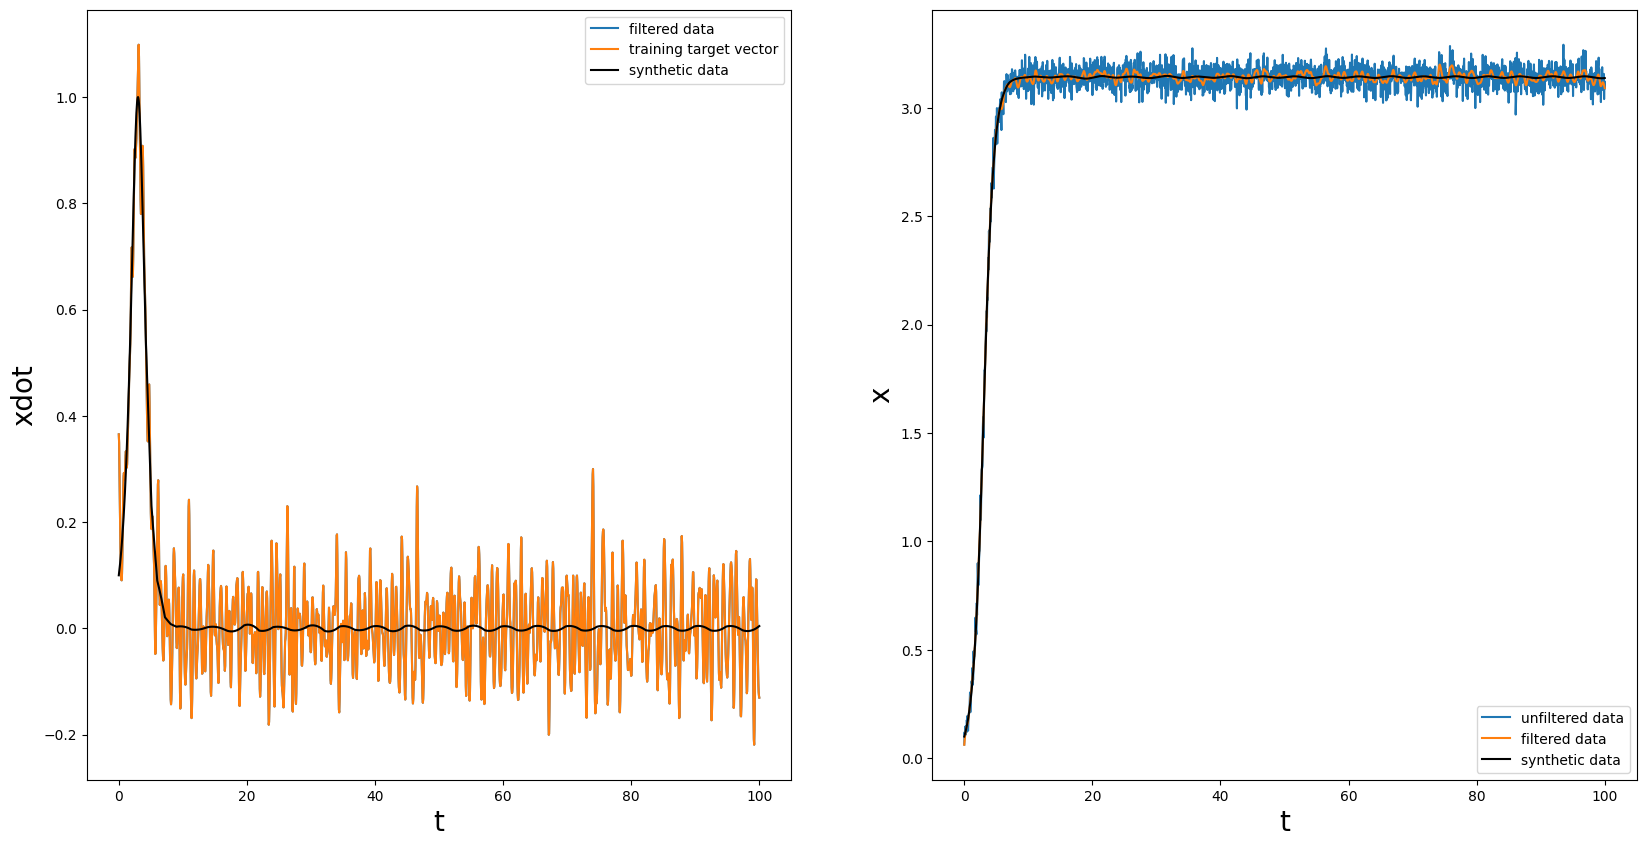

In [9]:
figure1, plot1 = plt.subplots(1,2)
# plot1[0].plot(t[10:-10], unfiltered_XDOT_TOTAL[10:-10,k], label = 'unfiltered data')
plot1[0].plot(t, XDOT_TOTAL[:,k], label = 'filtered data')
plot1[0].plot(t[:int(n)], XDOT, label = 'training target vector')
plot1[0].plot(t, synthetic_xdot[:,k], label = 'synthetic data', c='black')
# plot1[0].plot(t[:int(n)], checkxdot[:1000], label = 'checking target vector')
plot1[0].legend()
plot1[0].set_xlabel('t', fontsize=20)
plot1[0].set_ylabel('xdot', fontsize=20)
# plot1[0].set_ylim([-5,5])

plot1[1].plot(t[:int(n)], unfiltered_X[:,k], label = 'unfiltered data')
plot1[1].plot(t[:int(n)], X[:,k], label ='filtered data')
plot1[1].plot(t, synthetic_x[:,k], label = 'synthetic data', c='black')
plot1[1].set_xlabel('t', fontsize=20)
plot1[1].set_ylabel('x', fontsize=20)
# plot1[1].plot(t[:int(n)], checkx, label = 'check data')
plot1[1].legend()

figure1.set_figwidth(20)
figure1.set_figheight(10)

In [10]:
def get_library(functions, system_data):
    _library = CustomLibrary(library_functions=functions)
    _library.fit(system_data)
    _feature_library = np.array(_library.transform(system_data))
    _function_names = np.array(_library.get_feature_names())
    return _feature_library, _function_names

In [11]:
np.savetxt('xdat.csv', X, delimiter=',')
np.savetxt('xdotdat.csv', XDOT, delimiter=',')
# np.savetxt('dictionary.csv', FEATURE_LIBRARY, delimiter=',')
# np.savetxt('dictionary.csv', X, delimiter=',')
# np.savetxt('unfil_xdotdat.csv', unfiltered_XDOT, delimiter=',')
# # np.savetxt('unfil_dictionary.csv', unfiltered_FEATURE_LIBRARY, delimiter=',')
# np.savetxt('unfil_dictionary.csv', unfiltered_X_TOTAL, delimiter=',')
# # np.savetxt('function_names.csv', FUNCTION_NAMES, delimiter=',')